In [1]:
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa
from IPython.display import Audio
%matplotlib inline

import audio_utils
import vamp


In [2]:
audio_file = 'wav/hbd_snip.wav'
def melodic_frequency_filepath(filepath):
    audio, sr = librosa.load(filepath, mono=True)
    data = vamp.collect(audio, sr, "mtg-melodia:melodia")
    hop, melody = data['vector']
    return melody

def melodic_frequency(audio, sr):
    data = vamp.collect(audio, sr, "mtg-melodia:melodia")
    hop, melody = data['vector']
    return melody


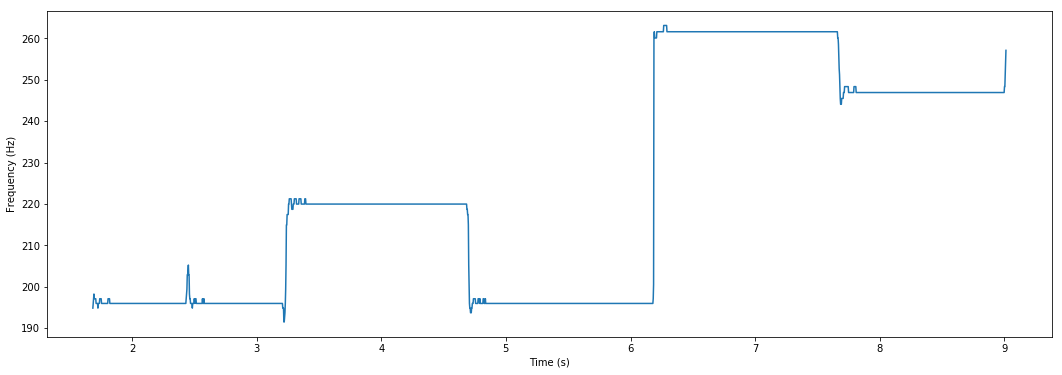

In [3]:
# A clearer option is to get rid of the negative values before plotting
melody = melodic_frequency_filepath('wav/hbd_snip.wav')
# for some reason the internal vamp architecture requires this
def plot_melody(melody):
    timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)
    melody_pos = melody[:]
    melody_pos[melody<=0] = None
    plt.figure(figsize=(18,6))
    plt.plot(timestamps, melody_pos)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()
    
plot_melody(melody)

In [4]:
# Audio(melody, rate=sr)
print(timestamps)

NameError: name 'timestamps' is not defined

In [6]:
vamp_constant = (128/44100.0)

def timestamp_to_index(timestamp):
    index = (timestamp - (8 * vamp_constant)) / vamp_constant
    return int(index)

def find_interval_freq(start_time, end_time, melody):
    start_index = timestamp_to_index(start_time)
    end_index = timestamp_to_index(end_time)
    
    relevant_frequencies = melody[start_index:end_index]
    
    freq = find_freq(relevant_frequencies)
    
    return freq

def find_freq(melody):
    voiced_frequencies = np.array([ freq for freq in melody if freq > 0 ])
    freq = np.median(voiced_frequencies)
    return freq



In [7]:
happy = find_pitch(2,3,melody)
birth = find_pitch(3.5, 4.5, melody)
day = find_pitch(5,6,melody)
to = find_pitch(6.5, 7.5, melody)
you = find_pitch(8,9, melody)
print(happy)
print(birth)
print(day)
print(to)
print(you)

NameError: name 'find_pitch' is not defined

In [8]:
ha = melodic_frequency('wav/hbd_speech_chunks/chunk0.wav')
py = melodic_frequency('wav/hbd_speech_chunks/chunk1.wav')
birth = melodic_frequency('wav/hbd_speech_chunks/chunk2.wav')
day = melodic_frequency('wav/hbd_speech_chunks/chunk3.wav')
toyou = melodic_frequency('wav/hbd_speech_chunks/chunk4.wav')

ha_pitch = np.median(ha)
py_pitch = np.median(py)
birth_pitch = np.median(birth)
day_pitch = np.median(day)
toyou_pitch = np.median(toyou)

print(ha_pitch)
print(py_pitch)
print(birth_pitch)
print(day_pitch)



TypeError: melodic_frequency() missing 1 required positional argument: 'sr'

In [9]:
def flatten(lst):
    flat_list = [item for sublist in lst for item in sublist]
    return flat_list


In [30]:
from gtts import gTTS
from pydub import AudioSegment

FILEPATH = 'tts_dump.mp3'

def tts(text):
    """
        returns list of AudioSegments corresponding to each word in text
    """
    tokens = text.split(' ')
    audio_chunks = [tts_word(token) for token in tokens]
    return audio_chunks

def tts_word(word):
    sound_obj = gTTS(word)
    sound_obj.save(FILEPATH)
    y = AudioSegment.from_mp3(FILEPATH)
    return y

Original


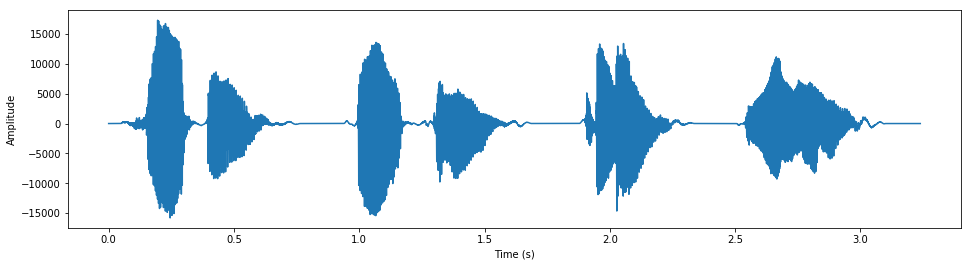

In [58]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

voice_sr = 22050
audio_words = tts('Happy birthday to you')

original_signal = np.concatenate([ np.array(word.get_array_of_samples()) for word in audio_words ])

print('Original')
IPython.display.display(Audio(original_signal, rate=voice_sr))
audio_utils.plot_audio(original_signal, sr=voice_sr)

audio_chunks = [split_on_silence(word, min_silence_len=15, silence_thresh=-25) for word in audio_words]
audio_chunks2 = flatten(audio_chunks)

all_segments = [np.array(chunk.get_array_of_samples(),dtype=float) for chunk in audio_chunks2]
# for segment in all_segments:
#     IPython.display.display(Audio(segment, rate=voice_sr))
#     audio_utils.plot_audio(segment, sr=voice_sr)

voice_chunk_melody = [melodic_frequency(chunk, voice_sr) for chunk in all_segments]

voice_chunk_freq = [find_freq(melody) for melody in voice_chunk_melody]


In [56]:
hbd_snip, sr = librosa.load("wav/hbd_snip.wav")
onset_frames = librosa.onset.onset_detect(hbd_snip, sr=sr)
onset_times = librosa.frames_to_time(onset_frames)

def onset_interval(i, onset_start, onset_times, last_timestamp):
    if i+1 >= len(onset_times):
        return (onset_start, last_timestamp)
    else:
        return (onset_start, onset_times[i+1])        

onset_intervals = [ onset_interval(i, onset, onset_times, len(hbd_snip)/ sr) for i, onset in enumerate(onset_times) ]

hbd_melody = melodic_frequency(hbd_snip, sr)
hbd_freqs = [find_interval_freq(start, end, hbd_melody) for start, end in onset_intervals]

print('onset times', onset_times)
print('onset intervals', onset_intervals)
print('voice freq', voice_chunk_freq)
print('hbd freq', hbd_freqs)


onset times [1.71827664 2.48453515 3.25079365 4.73687075 6.22294785 7.70902494]
onset intervals [(1.7182766439909296, 2.48453514739229), (2.48453514739229, 3.250793650793651), (3.250793650793651, 4.73687074829932), (4.73687074829932, 6.222947845804988), (6.222947845804988, 7.7090249433106575), (7.7090249433106575, 9.0)]
voice freq [251.25812, 126.35682, 187.14677, 130.05936, 140.20168, 204.085]
hbd freq [195.99771, 195.99771, 220.0, 195.99771, 261.62558, 246.94165]


Generated Happy Birthday Text


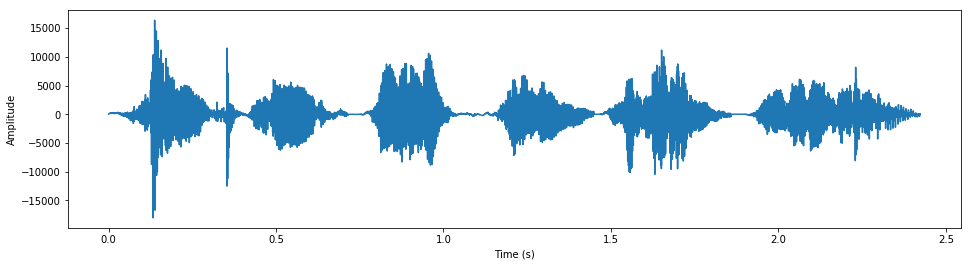

happy birthday notes


In [59]:
def autotune(signal_chunks, fn, f0, v_sr):
    shifted_signal = []
    length = min( len(fn), len(f0) )
    for i in range(length):

        n_steps = np.round(np.log2(float(fn[i])/f0[i]) * 12)

        shifted_segment = librosa.effects.pitch_shift(signal_chunks[i], v_sr, n_steps)
        shifted_signal.append(shifted_segment)
        
    return np.concatenate(shifted_signal)

tuned_signal = autotune(all_segments, hbd_freqs, voice_chunk_freq, voice_sr)



print("Generated Happy Birthday Text")

IPython.display.display(Audio(tuned_signal, rate=voice_sr))
audio_utils.plot_audio(tuned_signal, sr=voice_sr)

print('happy birthday notes')
IPython.display.display(Audio(hbd_snip, rate=voice_sr))

